In [46]:
from torchvision import transforms
from PIL import Image
import os
import torch
import numpy as np
rcParams['figure.figsize'] = (15,4)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [47]:
from src.utils import cascade
from src.u2net import U2NET

In [48]:
class Removal:
    def __init__(self, model_folder="model_folder/", L=300, device='cuda:0'):
        self.L = L
        self.device = device
        self.model_folder = model_folder
        self.transform_im = transforms.Compose([
                            transforms.Resize((128, 128)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        self.transform_ms = transforms.Compose([
                            transforms.Resize((128, 128)),
                            transforms.ToTensor()])
    def normPRED(self, d):
        ma = torch.max(d)
        mi = torch.min(d)
        return (d-mi)/(ma-mi)
        
    def pred(self, Image_root, show=True, return_mask=False):
        model = U2NET().to(self.device)
        model.load_state_dict(torch.load('u2net.pth'))
        model.eval()
        
        image = Image.open(Image_root)
        image_t = self.transform_im(image)
        mask = self.normPRED(model(image_t.reshape(1, 3, 128, 128).to(self.device))[0][0][0].cpu().detach()).numpy()
        
        mask_cascade = cascade(self.transform_ms(image), (mask>=0.2)*255, self.model_folder, self.device)
        
        empty = Image.new("RGBA", image.size, color = 0)
        mask1 = Image.fromarray(((mask_cascade>=254) * 255).astype(np.uint8)).resize(image.size)
        res = Image.composite(Image.open(Image_root), empty, mask1)
        if show:
            plt.imshow(res)
            plt.axis('off')
        if return_mask:
            return res, mask1
        return res

In [49]:
path_im = 'DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000025.jpg'
image = Removal()

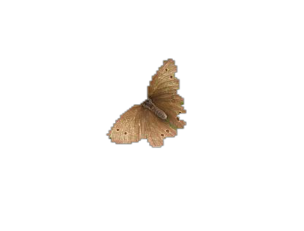

In [50]:
a = image.pred(path_im)